# Facility Data Deep Dive

## Violations, Inspections and Enforcements for the Resource Conservation and Recovery Act (RCRA), Clean Water Act (CWA), Clean Air Act (CAA)

This notebook examines data from the EPA's Enforcement and Compliance History Online (ECHO) database (https://echo.epa.gov/). It includes information from EPA's programs covering air (the Clean Air Act, or CAA), water (the Clean Water Act, or CWA) and hazardous and other waste handling (the Resource Recovery and Conservation Act, or RCRA). ECHO data is available here on inspections, violations and enforcements by EPA, state and other agencies. Information made accessible here runs from the present day (the database is refreshed weekly) back to whenever ECHO data begins on a particular program (varying from the 1970s to the 2000s). It uses the following data sets from the ECHO downloadable files:

Hazardous and Other Wastes:
- RCRA_EVALUATIONS = Inspections under RCRA
- RCRA_VIOLATIONS = Violations of RCRA rules
- RCRA_ENFORCEMENTS = Enforcement actions takenby state agencies and the EPA

Cross-Program Compilations:
- ICIS_FEC_EPA_INSPECTIONS = Cross-program, federally-led inspections 
- CASE_FACILITIES = Cross-program enforcements
- ECHO_EXPORTER = A cross-program compilation of all information that is now available on the EPA's public interface for ECHO; mostly limited to the last 3-5 years of data

Air:
- ICIS-AIR_VIOLATION_HISTORY = CAA violations
- ICIS-AIR_FCES_PCES = Both state and federal CAA compliance evaluations
- ICIS-AIR_FORMAL_ACTIONS = CAA formal enforcement actions

Air Emissions:
    (Combined air emissions data for stationary sources from four EPA air programs: National Emissions Inventory (NEI), Greenhouse Gas Reporting Program (GHGRP), Toxic Release Inventory (TRI), and Clean Air Markets (CAMD))
- Greenhouse Gas via POLL_RPT_COMBINED_EMISSIONS 
- Toxic Releases via POLL_RPT_COMBINED_EMISSIONS 

Water:
- NPDES_QNCR_HISTORY = CWA Quarterly Non-Compliance History
- NPDES_INSPECTIONS = CWA Inspections
- NPDES_FORMAL_ENFORCEMENT_ACTIONS = CWA Enforcements

Drinking Water:
- SDWA_PUB_WATER_SYSTEMS = Public Water Systems under Safe Drinking Water Act
- SDWA_SITE_VISITS = Safe Drinking Water Site Visits
- SDWA_VIOLATIONS = Safe Drinking Water Violations
- SDWA_SERIOUS_VIOLATORS = Safe Drinking Water Serious Violators
- SDWA_ENFORCEMENTS = Safe Drinking Water Enforcements
- SDWA_RETURN_TO_COMPLIANCE = Safe Drinking Water Return to Compliance

#### For starters, please have available the zip code of the facility or area in which you area interested.  
A "cell" in a Jupyter notebook is a block of code performing a set of actions making available or using specific data.  The notebook works by running one cell after another, as the notebook user selects offered options.

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!

---
---

# **Let's begin!**

### Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.

#### These first two cells give us access to some external Python code we will need.
### 1.  Bring in some code that is stored in a Guthub project.

In [180]:
!git clone https://github.com/edgi-govdata-archiving/ECHO_modules.git

Cloning into 'ECHO_modules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 24 (delta 6), reused 13 (delta 4), pack-reused 0
Unpacking objects: 100% (24/24), 6.05 KiB | 72.00 KiB/s, done.


### 2.  Run an external Python module.

In [181]:
%run ECHO_modules/DataSet.py

### 3.  Run this next cell to create the widget to choose whether you want to view facilities by state, county, congressional district or zip code.  Choose the type of region and proceed to the next cell.

In [197]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

from IPython.display import display

# ECHO_EXPORTER has counties listed both as ALAMEDA and ALAMEDA COUNTY, seemingly
# for every county.  We drop the 'COUNTY' so they only get listed once.
def fix_county_names( in_counties ):
    counties = []
    for county in regions['FAC_COUNTY']:
        if (county.endswith( ' COUNTY' )):
            county = county[:-7]
        counties.append( county.strip() )
    counties = np.unique( counties )
    return counties

region_field = { 
    'State': { "field": 'FAC_STATE' },
    'Congressional District': { "field": 'FAC_DERIVED_CD113' },
    'County': { "field": 'FAC_COUNTY' },
    'Zip Code': { "field": 'FAC_DERIVED_ZIP' }
}

style = {'description_width': 'initial'}
select_region_widget = widgets.Dropdown(
    options=region_field.keys(),
    style=style,
    value='County',
    description='Region of interest:',
    disabled=False
)
display( select_region_widget )

Dropdown(description='Region of interest:', index=2, options=('State', 'Congressional District', 'County', 'Zi…

### 4.  Select the state of interest.  If you are interested in a Zip code analysis, this can be skipped.

In [183]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI'…

### 5.  Run this cell for all types of regions.  
#### Here is a map of congressional districts: https://www.govtrack.us/congress/members/map

In [185]:
selected_region_type = select_region_widget.value
selected_region_field = region_field[ selected_region_type ]

if ( selected_region_type != 'Zip Code' ):
    my_state = dropdown_state.value
    region_sql = "select distinct("
    region_sql += selected_region_field[ 'field' ] + ")"
    region_sql += " from ECHO_EXPORTER "
    region_sql += " where FAC_STATE = \'" + my_state + "\'"
    try:
        regions = get_data( region_sql )
    except pd.errors.EmptyDataError:
        print("\nThere are no regions of that type in this state.\n")

if ( selected_region_type == 'Zip Code' ):
    region_widget = widgets.IntText(
        value=98225,
        description='Zip Code:',
        disabled=False
    )
elif ( selected_region_type == 'County' ):
    region_widget=widgets.Dropdown(
        options=fix_county_names( regions['FAC_COUNTY'] ),
        description='County:',
        disabled=False
    )
elif ( selected_region_type == 'Congressional District' ):
    region_widget=widgets.Dropdown(
        options=regions['FAC_DERIVED_CD113'].sort_values(),
        description='District:',
        disabled=False
    )
   
if ( selected_region_type != 'State' ):
    display( region_widget )

Dropdown(description='District:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 1…

### 6. Run this cell. It will pull facility information from the data  in the  ECHO_EXPORTER table.

In [186]:
region_selected = region_widget.value

if ( selected_region_type == 'State' ):
    region_selected = my_state
echo_data_sql = "select * from ECHO_EXPORTER where " + region_field[selected_region_type]['field']
if ( selected_region_type == 'Congressional District' ):
    echo_data_sql += " = \'" + str( region_selected ) + "'"
else:    
    echo_data_sql += " like \'" + str( region_selected) + "%\'"
if ( selected_region_type != 'Zip Code' ):
    echo_data_sql += " and FAC_STATE = \'" + my_state + "\'"
try:
    echo_data = get_data( echo_data_sql, 'REGISTRY_ID' )
    num_facilities = echo_data.shape[0]
    print("\nThere are %s EPA facilities in region %s tracked in the ECHO database." \
          %(num_facilities, str( region_selected )))
except pd.errors.EmptyDataError:
    print("\nThere are no EPA facilities in this region.\n")


There are 3542 EPA facilities in region 1 tracked in the ECHO database.


## Create an interactive map of all of the facilities in the area that report to EPA
### 7. Once you run this cell, a map should appear. You can zoom in and out, or click on facilities to get their names and the EPA programs that monitor them.

The EPA program acronyms are:
- CAA = Clean Air Act
- CWA = Clean Water Act
- SDWIS = Safe Drinking Water Information System
- RCRA = Resource Conservation and Recovery Act
- TRI = Toxics Release Inventory
- GHG = Greenhouse Gas

The map won't display if there are too many markers, so only the first 400 are shown. 
The facilities shown are selected in order of the ECHO_EXPORTER table's FAC_QTRS_WITH_NC field, which is defined as a "Count of the number of quarters, out of the last twelve quarters, in which the permit or site is considered either in Noncompliance (NC), Significant Noncompliance (SNC) or High Priority violation (HPV) status."

In [187]:
# Let's show a quick map of your area and the facilities in it
# To-do:  Add some more ECHO_EXPORTER information in the markers.

# Put some information with the marker to show the programs that track the facility.
def marker_text( row ):
    text = ""
    if ( type( row['FAC_NAME'] == str )) :
        try:
            text = row["FAC_NAME"] + ' - '
        except TypeError:
            print( "A facility was found without name. ")
        if ( row['AIR_FLAG'] == 'Y' ):
            text += 'CAA, ' 
        if ( row['NPDES_FLAG'] == 'Y' ):
            text += 'CWA, ' 
        if ( row['SDWIS_FLAG'] == 'Y' ):
            text += 'SDWIS, ' 
        if ( row['RCRA_FLAG'] == 'Y' ):
            text += 'RCRA, ' 
        if ( row['TRI_FLAG'] == 'Y' ):
            text += 'TRI, ' 
        if ( row['GHG_FLAG'] == 'Y' ):
            text += 'GHG, ' 
    return text
    
def mapper(df):
    # Initialize the map
    center = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]]
    m = folium.Map(
        location = center,
    )

    # Add a clickable marker for each facility
    i = 0
    for index, row in df.iterrows():
        # Make sure the FAC_NAME is not NaN, which is interpreted as a number.
        if ( type( row['FAC_NAME'] == str )) :
            folium.Marker(
                location = [row["FAC_LAT"], row["FAC_LONG"]],
                popup = marker_text( row )).add_to(m)
            i += 1
        if ( i > 400 ):    # The map won't display with too many markers.
            break
            
    bounds = m.get_bounds()
    m.fit_bounds(bounds)
    
    # Show the map
    return m

df_to_map = echo_data
if ( len(df_to_map) > 400 ):
    df_to_map = echo_data[echo_data["FAC_QTRS_WITH_NC"] > 0].sort_values(by="FAC_QTRS_WITH_NC", ascending=False)
    
map_of_facilities = mapper(df_to_map)
map_of_facilities

## In this section you may save the region's data to your computer.
### 8. This next cell allows you to save the data from ECHO_EXPORTER for your chosen region to your computer.  
#### Note: This will save all of the facilities, monitored under any EPA program.  You have the opportunity later to save information on only those facilities monitored under a specific EPA program.
_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [171]:
if ( len( echo_data ) > 0 ):
    filename = 'ECHO_EXPORTER-' + str( region_selected )
    fullpath = filename+'.csv'
    echo_data.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no facility data for this region." )

Wrote ECHO_EXPORTER-1 to the Google Colab 'Files' menu as ECHO_EXPORTER-1.csv


We need to set up some data structures in this next cell that will be used in the remainder of the report.

## Graph program-specific data for all the facilities in the region.
### First, choose the program (Air, Water, or RCRA) and type of data (Violations, Inspections, Enforcement) you want to explore

Running the code below will show you a dropdown you can use to make a selection. **Inspections** or **evaluations** are usually the first phase in the enforcement pipeline, how many (but not all) violations are discovered.  **Violations** happen when a facilty is found to be out of compliance with an environmental law, often by violating the terms of its permit issued under that law.  **Enforcement actions** happen when the regulating agency decides to initiate a "case" against a firm for its violation of an environmental law, either by considering some administrative penalty such as a fine or by taking the violator to court. 

What's available for you to look at here:

Hazardous and Other Waste:
- RCRA_EVALUATIONS = Inspections under RCRA
- RCRA_VIOLATIONS = Violations of RCRA rules
- RCRA_ENFORCEMENTS = Enforcement actions taken by state agencies and the EPA

Here's where you can find definitions of terms used in the columns of RCRA data: 
https://echo.epa.gov/tools/data-downloads/rcrainfo-download-summary 
- ~~ICIS_FEC_EPA_INSPECTIONS = Cross-program, federally-led inspections~~ (TBD)  
- ~~CASE_FACILITIES = Cross-program enforcements~~ (TBD)

Air:
- ICIS-AIR_VIOLATION_HISTORY = CAA violations
- ICIS-AIR_FCES_PCES = Both state and federal CAA compliance evaluations
- ICIS-AIR_FORMAL_ACTIONS = CAA formal enforcement actions

Here's where you can find definitions of terms used in the columns of Clean Air Act data: 
https://echo.epa.gov/tools/data-downloads/icis-air-download-summary

Air Emissions (Combined air emissions data for stationary sources from four EPA air programs: National Emissions Inventory (NEI), Greenhouse Gas Reporting Program (GHGRP), Toxic Release Inventory (TRI), and Clean Air Markets (CAMD)):
- Greenhouse Gases via POLL_RPT_COMBINED_EMISSIONS
- Toxic Releases via POLL_RPT_COMBINED_EMISSIONS

Here's where you can find definitions of terms used in the columns of this data: https://echo.epa.gov/tools/data-downloads/air-emissions-download-summary

Water (National Pollutant Discharge Elimination System, or NPDES):
- NPDES_QNCR_HISTORY = CWA Quarterly Non-Compliance History
- NPDES_INSPECTIONS = CWA Inspections
- NPDES_FORMAL_ENFORCEMENT_ACTIONS = CWA Enforcements

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/icis-npdes-download-summary

Drinking Water (Safe Drinking Water Act, or SDWA):
- SDWA_PUB_WATER_SYSTEMS = Public Water Systems under Safe Drinking Water Act
- SDWA_SITE_VISITS = Safe Drinking Water Site Visits
- SDWA_VIOLATIONS = Safe Drinking Water Violations
- SDWA_SERIOUS_VIOLATORS = Safe Drinking Water Serious Violators
- SDWA_ENFORCEMENTS = Safe Drinking Water Enforcements
- SDWA_RETURN_TO_COMPLIANCE = Safe Drinking Water Return to Compliance

Here's where you can find definitions of terms used in the columns of Clean Water Act data: https://echo.epa.gov/tools/data-downloads/sdwa-download-summary


### 9. This cell creates data sets for facilities in the region and presents a dropdown selection.

In [188]:
%run make_data_sets.py

# Only list the data set if it has the correct flag set.
data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( echo_data ) ):
        data_set_choices.append( k )

# data_set_choices = list( data_sets.keys() )

data_set_widget=widgets.Dropdown(
    options=list(data_set_choices),
    description='Data sets:',
    disabled=False,
) 
display(data_set_widget)

Dropdown(description='Data sets:', options=('RCRA Violations', 'RCRA Inspections', 'RCRA Enforcements', 'Air I…

### 10. Once you've chosen the program and data type you want to focus on...
....run the code below, which will access our database and retrieve the information

In [189]:
program = data_sets[ data_set_widget.value ]
program_data = None
key=dict() # Create a way to look up Registry IDs in ECHO_EXPORTER later

# We need to provide a custom list of program ids for some programs.
if ( program.name == "Air Inspections" or program.name == "Air Enforcements" ):
    # The REGISTRY_ID field is the index of the echo_data
    registry_ids = echo_data[echo_data['AIR_FLAG'] == 'Y'].index.values
    key = { i : i for i in registry_ids }
    program_data = program.get_data( ee_ids=registry_ids )
elif ( program.name == "Combined Air Emissions" ):
    ghg_registry_ids = echo_data[echo_data['GHG_FLAG'] == 'Y'].index.values
    tri_registry_ids = echo_data[echo_data['TRI_FLAG'] == 'Y'].index.values
    id_set = set( ghg_registry_ids + tri_registry_ids )
    registry_ids = list(id_set)
    program_data = program.get_data( ee_ids=registry_ids )
    key = { i : i for i in registry_ids }
elif ( program.name == "Greenhouse Gases" or program.name == "Toxic Releases" ):
    program_flag = program.echo_type + '_FLAG'
    registry_ids = echo_data[echo_data[ program_flag ] == 'Y'].index.values
    program_data = program.get_data( ee_ids=registry_ids )
    key = { i : i for i in registry_ids }
else:
    ids_string = program.echo_type + '_IDS'
    ids = list()
    registry_ids = list()
    for index, value in echo_data[ ids_string ].items():
        try:
            for this_id in value.split():
                ids.append( this_id )
                key[this_id]=index
        except ( KeyError, AttributeError ) as e:
            pass
    program_data = program.get_data( ee_ids=ids )

# Find the facility that matches the program data, by REGISTRY_ID.  
# Add lat and lon, facility name and REGISTRY_ID as fac_registry_id. 
# (Note: not adding REGISTRY_ID right now as it is sometimes interpreted as an int and that messes with the charts...)
my_prog_data = pd.DataFrame()
no_data_ids = []

# Look through all the facilities in my area and program and get supplemental echo_data info
if (program_data is None): # Handle no data
    print("Sorry, we don't have data for this program! That could be an error on our part, or ECHO's, or because the data type doesn't apply to this area.")
else:
    for fac in program_data.itertuples():
        fac_id = fac.Index
        reg_id = key[fac_id] # Look up this facility's Registry ID through its Program ID
        try:
            echo_row = pd.DataFrame(echo_data.loc[reg_id].copy()).T.reset_index() # Find and filter to the corresponding row in ECHO_EXPORTER
            echo_row = echo_row[['FAC_NAME', 'FAC_LAT', 'FAC_LONG']] # Keep only the columns we need
            program_row =  pd.DataFrame([list(fac)[1:]], columns=program_data.columns.values) # Turn the program_data tuple into a DataFrame
            full_row = pd.concat([program_row, echo_row], axis=1) # Join the EE row df and the program row df
            frames = [my_prog_data, full_row]
            my_prog_data = pd.concat( frames, ignore_index=False)
        except KeyError:
            # The facility wasn't found in the program data.
            no_data_ids.append( fac.Index )

my_prog_data

...


,ACTIVITY_LOCATION,VIOLATION_TYPE,VIOLATION_TYPE_DESC,VIOL_DETERMINED_BY_AGENCY,DATE_VIOLATION_DETERMINED,ACTUAL_RTC_DATE,SCHEDULED_COMPLIANCE_DATE,FAC_NAME,FAC_LAT,FAC_LONG
0,NY,262.D,Standards Applicable to Recordkeeping and Repo...,S,10/07/1996,11/21/1996,10/17/1996,NYSDOT BIN 1064230,40.8684,-72.8097
0,NY,262.A,Standards Applicable to Generators of HW: General,S,10/26/1994,12/28/1994,12/26/1994,DOVER FINDINGS,40.8619,-73.157
0,NY,262.A,Standards Applicable to Generators of HW: General,S,04/12/1988,05/27/1988,06/09/1988,DOVER FINDINGS,40.8619,-73.157
0,NY,273.B,Standards for Universal Waste Management: Stan...,S,06/04/2009,08/17/2009,NaN,AMERICAN TISSUE CORP,40.8099,-73.2526
0,NY,268.A,Land Disposal Restrictions: General,S,06/28/1995,11/27/1995,07/28/1995,AMERICAN TISSUE CORP,40.8099,-73.2526
...,...,...,...,...,...,...,...,...,...,...
0,NY,XXS,State Statutory or Regulatory requirements tha...,S,05/06/2009,06/04/2009,NaN,CVS PHARMACY #2726,40.9443,-72.8386
0,NY,262.D,Standards Applicable to Recordkeeping and Repo...,S,05/06/2009,06/04/2009,NaN,CVS PHARMACY #2726,40.9443,-72.8386
0,NY,273.B,Standards for Universal Waste Management: Stan...,S,09/19/2016,10/19/2016,NaN,POSITIVE PROMOTIONS,40.8033,-73.2252
0,NY,261.A,ID and Listing of HW: General,S,09/19/2016,10/19/2016,NaN,POSITIVE PROMOTIONS,40.8033,-73.2252


### 11.  In this cell you may save the program data for your region to your computer.
This next cell allows you to save the data from the particular program for your chosen region to your computer.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [190]:
if ( len( my_prog_data ) > 0 ):
    filename = program.name + '-' + str( region_selected )
    fullpath = filename+'.csv'
    my_prog_data.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no data for this program and region." )

Wrote RCRA Violations-1 to the Google Colab 'Files' menu as RCRA Violations-1.csv


### 12. Let's make a chart out of this!

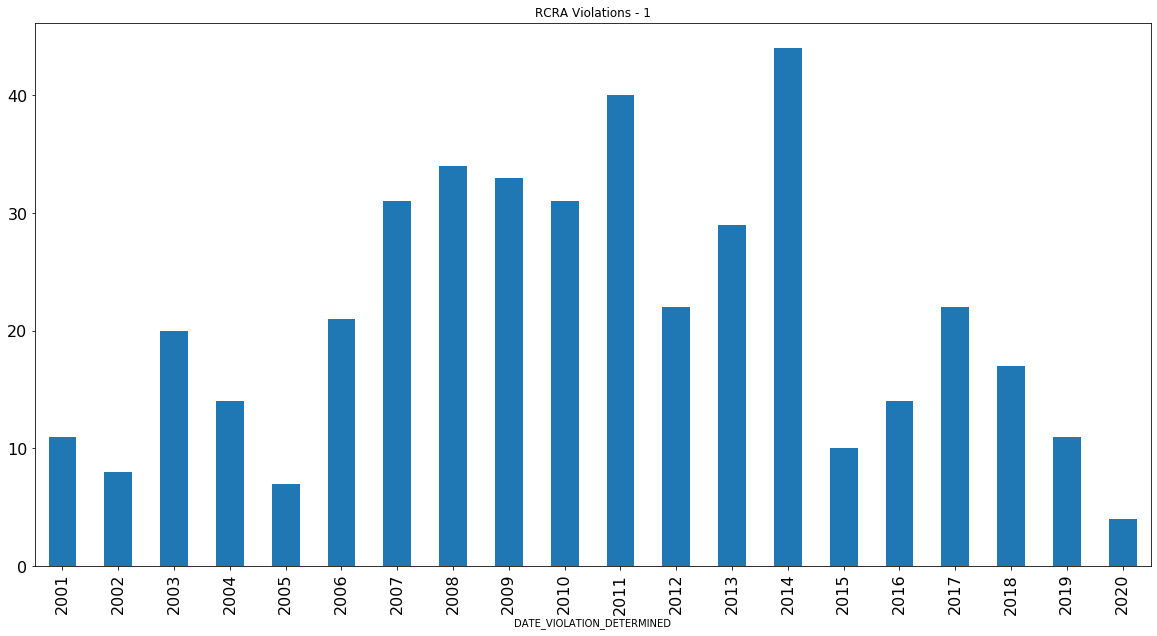

In [191]:
chart_title = program.name + ' - ' + str( region_selected )

# Handle NPDES_QNCR_HISTORY because there are multiple counts we need to sum
if (program.name == "Water Quarterly Violations"): 
    year = my_prog_data["YEARQTR"].astype("str").str[0:4:1]
    my_prog_data["YEARQTR"] = year
    d = my_prog_data.groupby(pd.to_datetime(my_prog_data['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
    d.index = d.index.strftime('%Y')
    d = d[ d.index > '2000' ]
    
    ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax
# These data sets use a FISCAL_YEAR field
elif (program.name == "SDWA Public Water Systems" or program.name == "SDWA Violations" or
     program.name == "SDWA Serious Violators" or program.name == "SDWA Return to Compliance"):
    year = my_prog_data["FISCAL_YEAR"].astype("str")
    my_prog_data["FISCAL_YEAR"] = year
    d = my_prog_data.groupby(pd.to_datetime(my_prog_data['FISCAL_YEAR'], format="%Y").dt.to_period("Y"))[['PWS_NAME']].count()
    d.index = d.index.strftime('%Y')
    d = d[ d.index > '2000' ]
    
    ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax        
elif (program.name == "Combined Air Emissions" or program.name == "Greenhouse Gases" \
          or program.name == "Toxic Releases"):
    d = my_prog_data.groupby( 'REPORTING_YEAR' )[['ANNUAL_EMISSION']].sum()
    ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax.set_xlabel( 'Reporting Year' )
    ax.set_ylabel( 'Pounds of Emissions')
    ax        
# All other programs
else:
    try:
        d = my_prog_data.groupby(pd.to_datetime(my_prog_data[program.date_field], format=program.date_format))[[program.date_field]].count()
        d = d.resample("Y").count()
        d.index = d.index.strftime('%Y')
        d = d[ d.index > '2000' ]
        
        if ( len(d) > 0 ):
            ax = d.plot(kind='bar', title = chart_title, figsize=(20, 10), legend=False, fontsize=16)
            ax
        else:
            print( "There is no data for this program and region." )
        
    except AttributeError:
        print("There's no data to chart for " + program.name + " !")

### 13. Show the facilities in the region in this data set.

In [192]:
df_to_map = None
if ( program.echo_type == 'SDWA' ):
    df_to_map = echo_data[ echo_data[ 'SDWIS_FLAG' ] == 'Y' ].copy()
elif ( program.name == 'Combined Air Emissions' ):
    df_to_map = echo_data[echo_data['GHG_FLAG'] == 'Y'].copy()
    df_to_map.append( echo_data[echo_data['TRI_FLAG'] == 'Y'] )
    df_to_map.drop_duplicates( inplace=True )
else:
    flag = program.echo_type + '_FLAG'
    df_to_map = echo_data[ echo_data[ flag ] == 'Y' ].copy()
map_of_facilities = mapper(df_to_map)
map_of_facilities

### 14. You may save the facility data for the selected EPA program and your region
This next cell lets you to save the data for facilities in this region monitored 
under the selected EPA program.

In [193]:
if ( len( df_to_map ) > 0 ):
    filename = 'ECHO_EXPORTER-' + program.name + '-' + str( region_selected )
    fullpath = filename+'.csv'
    df_to_map.to_csv( fullpath ) 
    print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))
else:
    print( "There is no facility data for this program and region." )

Wrote ECHO_EXPORTER-RCRA Violations-1 to the Google Colab 'Files' menu as ECHO_EXPORTER-RCRA Violations-1.csv


### If you'd like to look at another dimension of ECHO data for this region...
....return to the dropdown menu above and choose a different program/data type, run the database access code, and then chart and map it!

---

## Choose a specific facility
### 15. In the next few blocks of code, you can focus in on just one of these facilities in the region.
Run the below cell, then choose a facility from the dropdown that appears.

In [200]:
cd_array = echo_data["FAC_NAME"].dropna().unique()
cd_array.sort()

style = {'description_width': 'initial'}
fac_widget=widgets.Dropdown(
    options=cd_array,
    style=style,
    layout=Layout(width='70%'),
    description='Facility Name:',
    disabled=False,
)
display(fac_widget)

Dropdown(description='Facility Name:', layout=Layout(width='70%'), options=('106TH RESCUE WING, NEW YORK AIR N…

### 16. The next cell filters the program-specific IDs to get just records for the selected facility.
Running this cell will create a dropdown list of the program data sets available specifically for this faciliity. Pick one and then run the second cell to view its contents.

In [201]:
my_fac_name = fac_widget.value
my_fac = echo_data[echo_data["FAC_NAME"] == my_fac_name]

data_set_choices = []
for k, v in data_sets.items():
    if ( v.has_echo_flag( my_fac ) ):
        data_set_choices.append( k )

data_set_widget2=widgets.Dropdown(
    options=data_set_choices,
    description='Data sets:',
    disabled=False,
)
display(data_set_widget2)

Dropdown(description='Data sets:', options=('RCRA Violations', 'RCRA Inspections', 'RCRA Enforcements'), value…

### 17. Let's see the data for this facility

In [203]:
fac_program = data_sets[ data_set_widget2.value ]

ids = None
ids_string = None
if ( fac_program.idx_field != "REGISTRY_ID" ):
    # This doesn't work for REGISTRY_ID, and we make our list differently 
    # for programs that have that field as their index.
    ids_string = fac_program.echo_type + '_IDS'
    ids = my_fac.loc[my_fac[ids_string].str.len() >0]    # just give all _IDs and let sql deal with it?
    ids = ids.loc[:,ids_string].unique()

# We need to provide a custom sql query and argument for these programs.
if ( fac_program.name == "Air Inspections" or program.name == "Air Enforcements" ):
    # The REGISTRY_ID field is the index of the echo_data
    # Build a string
    registry_ids = my_fac[my_fac['AIR_FLAG'] == 'Y'].index.to_list()
    # breakpoint()
    this_data = fac_program.get_data( ee_ids=registry_ids )
elif ( fac_program.name == "Combined Air Emissions" ):
    ghg_registry_ids = my_fac[my_fac['GHG_FLAG'] == 'Y'].index.to_list()
    tri_registry_ids = my_fac[my_fac['TRI_FLAG'] == 'Y'].index.to_list()
    id_set = set( ghg_registry_ids + tri_registry_ids )
    this_data = fac_program.get_data( ee_ids=list(id_set) )
elif ( fac_program.name == "Greenhouse Gases" or fac_program.name == "Toxic Releases" ):
    program_flag = fac_program.echo_type + '_FLAG'
    registry_ids = my_fac[my_fac[ program_flag ] == 'Y'].index.to_list()
    this_data = fac_program.get_data( ee_ids=registry_ids )
else:
    this_data = fac_program.get_data( ee_ids=ids )
if ( this_data is None ):
    print( "There is no {} data for {} ".format( fac_program.name, my_fac_name ))
else:
    print( this_data )

             ACTIVITY_LOCATION  EVALUATION_IDENTIFIER EVALUATION_TYPE  \
ID_NUMBER                                                               
NYD987031028                NY                      1             CEI   

                                       EVALUATION_DESC EVALUATION_AGENCY  \
ID_NUMBER                                                                  
NYD987031028  COMPLIANCE EVALUATION INSPECTION ON-SITE               S     

             EVALUATION_START_DATE FOUND_VIOLATION  
ID_NUMBER                                           
NYD987031028            12/18/2014             N    


### 18. We can make a chart

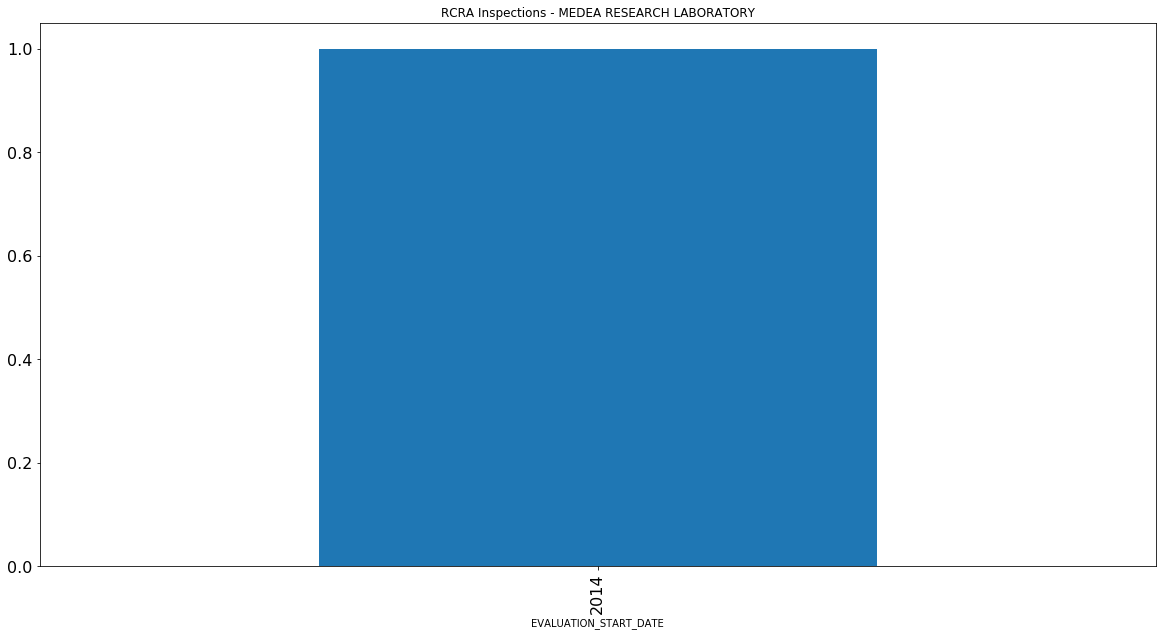

In [204]:
# Handle NPDES_QNCR_HISTORY because there are multiple counts we need to sum
fac_program_data = this_data
chart_title = fac_program.name + ' - ' + my_fac_name

if (fac_program.name == "Water Quarterly Violations"): 
    year=fac_program_data["YEARQTR"].astype("str").str[0:4:1]
    fac_program_data["YEARQTR"]=year
    fac_program_data = fac_program_data.groupby(pd.to_datetime(this_data['YEARQTR'], format="%Y").dt.to_period("Y")).sum()
    fac_program_data.index = fac_program_data.index.strftime('%Y')
    fac_program_data = fac_program_data[ fac_program_data.index > '2000' ]
    
    ax = fac_program_data.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax
    
# These data sets use a FISCAL_YEAR field
elif (fac_program.name=="SDWA Water Systems" or fac_program.name=="SDWA Violations" or
     fac_program.name=="SDWA Serious Violators" or fac_program.name=="SDWA Return to Compliance"):
    year = fac_program_data["FISCAL_YEAR"].astype("str")
    fac_program_data["FISCAL_YEAR"] = year
    fac_program_data = fac_program_data.groupby(pd.to_datetime(fac_program_data['FISCAL_YEAR'], 
                                                       format="%Y").dt.to_period("Y"))[['PWS_NAME']].count()
    fac_program_data.index = fac_program_data.index.strftime('%Y')
    fac_program_data = fac_program_data[ fac_program_data.index > '2000' ]
    
    ax = fac_program_data.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax        

elif (program.name == "Combined Air Emissions" or program.name == "Greenhouse Gases" \
          or program.name == "Toxic Releases"):
    fac_annual = fac_program_data.groupby( 'REPORTING_YEAR' )['ANNUAL_EMISSION'].sum()
    ax = fac_annual.plot(kind='bar', title = chart_title, figsize=(20, 10), fontsize=16)
    ax.set_xlabel( 'Reporting Year' )
    ax.set_ylabel( 'Pounds of Emissions')
    ax        
# All other data sets
else: 
    try:
        fac_program_data = fac_program_data.groupby(pd.to_datetime(fac_program_data[fac_program.date_field], 
                                                           format=fac_program.date_format))[[fac_program.date_field]].count()
        fac_program_data = fac_program_data.resample("Y").count()
        fac_program_data.index = fac_program_data.index.strftime('%Y')
        fac_program_data = fac_program_data[ fac_program_data.index > '2000' ]
        
        ax = fac_program_data.plot(kind='bar', title = chart_title, 
                               figsize=(20, 10), legend=False, fontsize=16)
        ax
        
    except AttributeError:
        print("There's no {} data to chart for {}!".format( fac_program.name, my_fac_name ))

### 19. This cell saves this facility's data for this program to your computer.
The next cell exports this data to your computer.  You can return to the dropdown to export additional data files.

_Note: When you click on [] in the cell, it may continue to show \*. That's to be expected! Check your Downloads folder and confirm that the spreadsheet was succesfully exported. Hit the square button (Interrupt Kernel) at the top of the page. You can now choose to export other data sets from the dropdown..._

In [ ]:
# Find the facility that matches the program data, by REGISTRY_ID.  
# Add lat and lon, facility name and REGISTRY_ID as fac_registry_id.
# (The program data may alread have a REGISTRY_ID field.)

my_prog_data = pd.DataFrame()
no_data_ids = []

for fac in my_fac.itertuples():
    break
    
fac_id = fac.Index
try:
    program_rows = this_data.loc[ fac_id ].copy()
    n = program_rows.shape[0]
    fac_list = [fac_id] * n
    fac_names = [fac.FAC_NAME] * n
    fac_lats = [fac.FAC_LAT] * n
    fac_longs = [fac.FAC_LONG] * n
    program_rows['fac_registry_id'] = fac_list
    program_rows['FAC_NAME'] = fac_names
    program_rows['FAC_LAT'] = fac_lats
    program_rows['FAC_LONG'] = fac_longs
    # breakpoint()
    frames = [my_prog_data, program_rows]
    my_prog_data = pd.concat( frames, ignore_index=False)
except KeyError:
    # The facility wasn't found in the program data.
    no_data_ids.append( fac.Index )
    
filename = fac_program.name + '-' + my_fac_name
fullpath = filename+'.csv'
my_prog_data.to_csv( fullpath ) 

print( "Wrote "+filename+" to the Google Colab 'Files' menu as %s" %(fullpath))

### Accessing your files
Click on the 'Files' tab in the menu on the left-hand side of the notebook (it looks like a folder). You may have to hit 'Refresh' if you don't see your file. Then, you can click on the ... next to your file and choose "Download". The CSV spreadsheet will download to wherever your browser usually saves files (e.g. Downloads folder)

### If you'd like to look at another dimension of ECHO data for this facility...
....return to the dropdown menu above and choose a different program/data type, then chart it!